In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
%matplotlib inline

In [90]:
def generate_model(data: np.ndarray, split_factor=0.6):
    T = len(data)
    # Splitting the data
    split_point = int(T * split_factor)
    train_data = data[:split_point]
    test_data = data[split_point:]

    # Corresponding time points for train and test data
    t_train = list(range(split_point))
    t_test = list(range(split_point, T))

    lc0 = np.log(train_data[0])

    # Create the model using only training data
    with pm.Model() as WrightModel:

        # Define priors and logistic model for the training data
        # L = pm.Normal("L", mu=10, sigma=5)
        # k = pm.HalfNormal("k", sigma=2)
        # t0 = pm.Normal("t0", mu=50, sigma=10)
        # rho = pm.Uniform("rho", lower=-1, upper=1)
        # sigma = pm.HalfNormal("sigma", sigma=1)
        WrightModel.add_coord("train_id", t_train)
        WrightModel.add_coord(
            "train_id_minus_one", t_train[1:]
        )  # For variables that start from t=1

        omega = pm.Normal("omega", sigma=1)
        rho = pm.Uniform("rho", lower=-1, upper=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        # Initial epsilon is explicitly set to zero for noise[0] = 0
        epsilon = pm.Normal("epsilon", mu=0, sigma=sigma, dims="train_id")
        epsilon_initial = pm.Deterministic(
            "epsilon_initial", pm.math.concatenate([[0], epsilon])
        )

        # MA1 noise term
        noise = epsilon_initial[1:] + rho * epsilon_initial[:-1]

        avg_deployment = -pm.HalfNormal("avg_deployment", sigma=1)
        std_deployment = pm.HalfNormal("std_deployment", sigma=1)

        log_deployment = pm.Normal(
            "log_deployment", mu=avg_deployment, sigma=std_deployment, dims="train_id"
        )

        # Likelihood for training data
        Y_obs = pm.Normal(
            "Y_obs",
            mu=lc0 + omega * log_deployment + noise,
            observed=np.log(train_data),
        )

        # Sample from the posterior
        idata = pm.sample(2000, target_accept=0.95)
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, WrightModel

In [91]:
import pandas as pd

In [92]:
df = pd.read_csv("../HPITPdata.csv", header=[0, 1, 2], index_col=0)

In [93]:
photovoltaics = df["Photovoltaics"].iloc[:, 0]

In [94]:
data = photovoltaics.dropna()

In [95]:
data

1980    22.557508
1981    17.180039
1982    17.444506
1983    16.392489
1984    13.366448
1985    12.203395
1986    11.434347
1987     9.547167
1988     9.454651
1989     9.537100
1990     9.738848
1991     9.071852
1992     8.572511
1993     7.643175
1994     7.472131
1995     6.916482
1996     5.758729
1997     5.709597
1998     4.798070
1999     4.391411
2000     3.568907
2001     3.372215
2002     3.440894
2003     3.251071
2004     3.451135
2005     3.488009
2006     3.801909
2007     3.830067
2008     3.490604
2009     2.333068
2010     1.556384
2011     1.415067
2012     0.764410
2013     0.821315
Name: (2013 USD/Wp, 4), dtype: float64

In [96]:
idata, model = generate_model(data.values, split_factor=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, rho, sigma, epsilon, avg_deployment, std_deployment, log_deployment]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

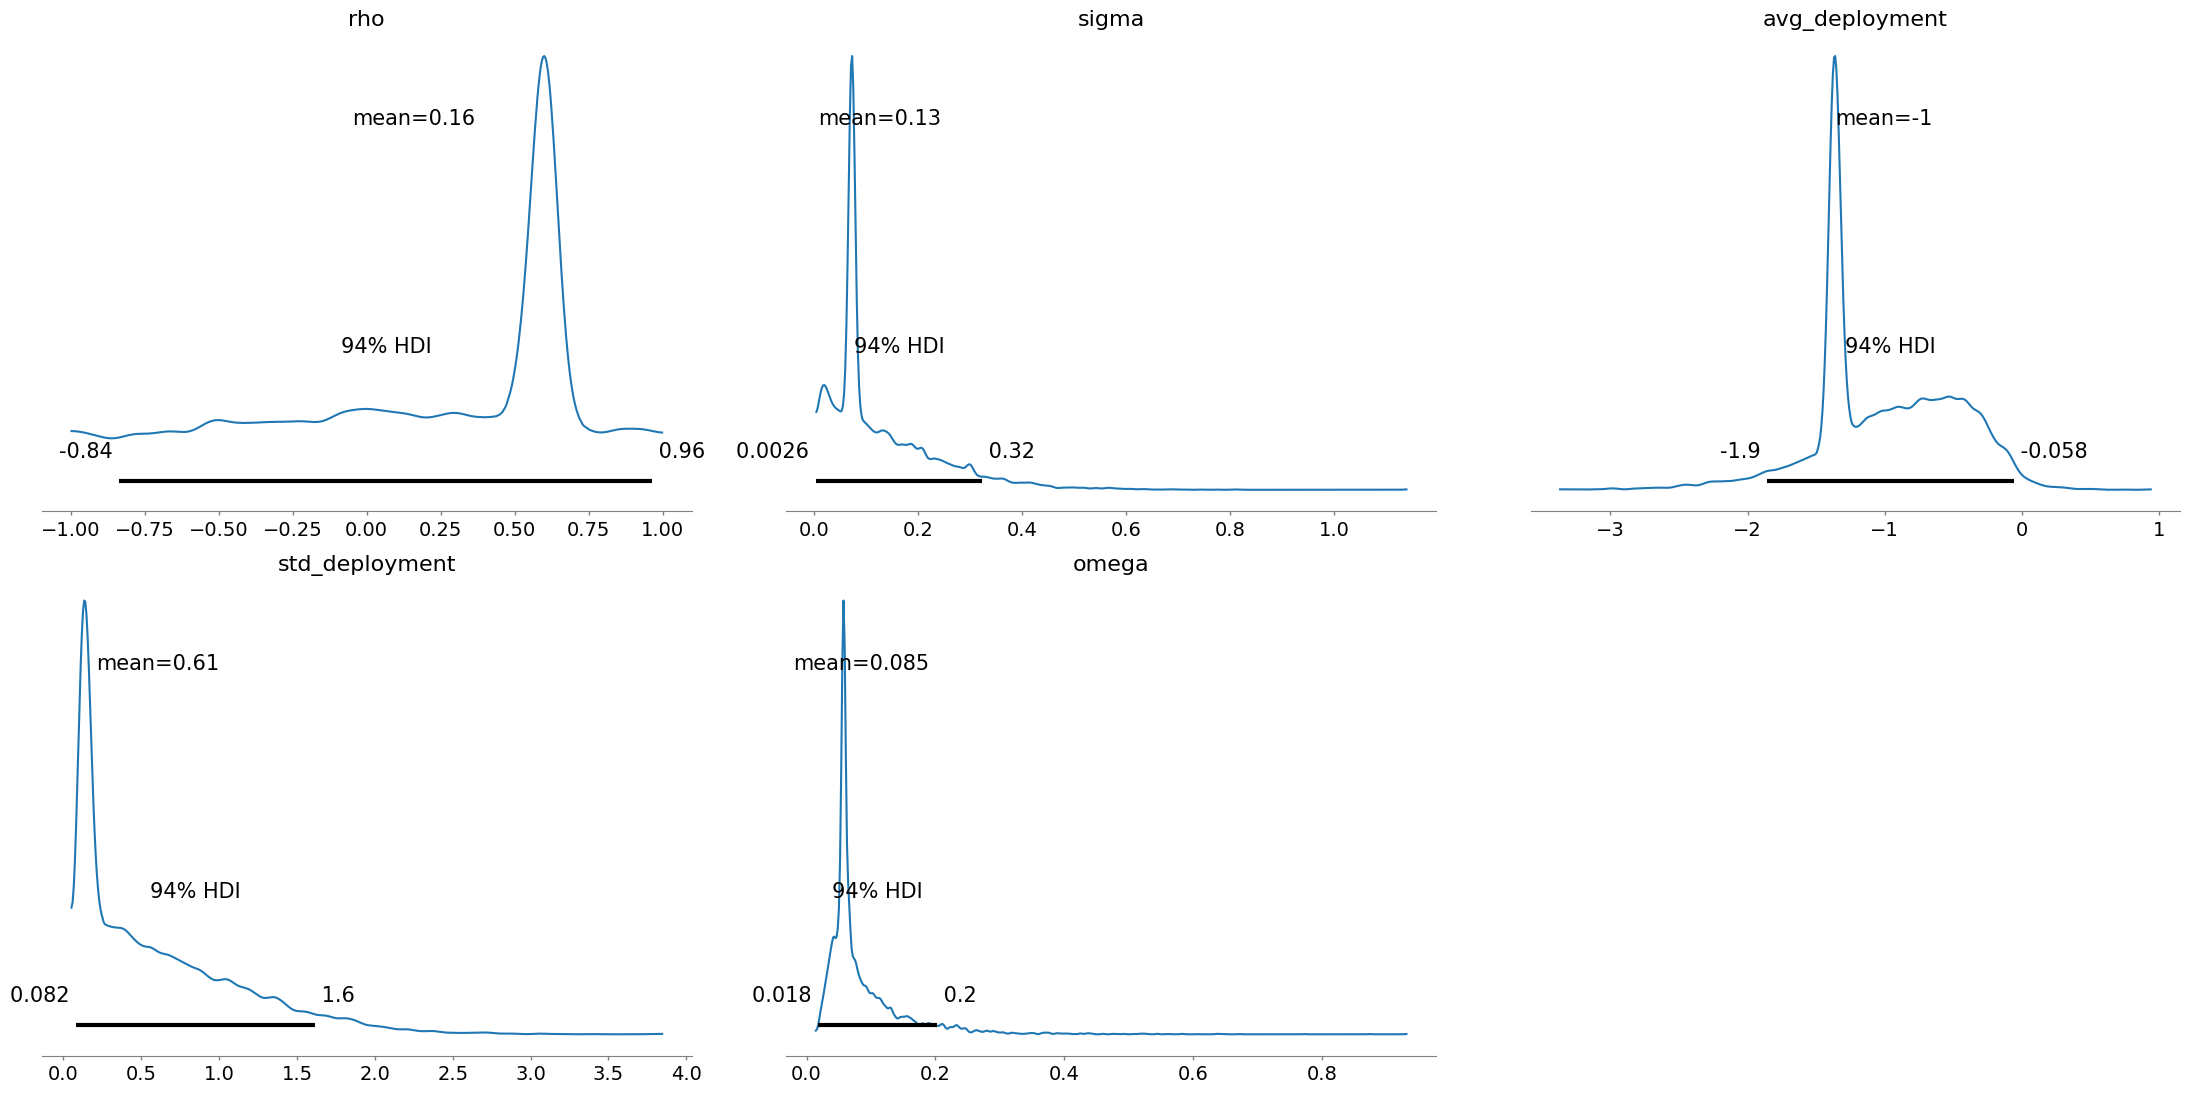

In [14]:
# Plotting posterior distributions
az.plot_posterior(
    idata, var_names=["rho", "sigma", "avg_deployment", "std_deployment", "omega"]
)
plt.tight_layout()

In [15]:
def wright_law(t_max, c0, omega, rho, sigma, avg_deployment, std_deployment):
    t = np.arange(t_max)
    lc0 = np.log(c0)
    epsilon = np.random.normal(0, sigma, t_max)
    epsilon_initial = np.concatenate([[0], epsilon])
    noise = epsilon_initial[1:] + rho * epsilon_initial[:-1]
    log_deployment = np.cumsum(np.random.normal(avg_deployment, std_deployment, t_max))
    return np.exp(lc0 + omega * log_deployment + noise)


def wright_law_noisefree(t_max, c0, omega, rho, log_deployment, epsilon):
    t = np.arange(t_max)
    lc0 = np.log(c0)
    epsilon_initial = np.concatenate([[0], epsilon])
    noise = epsilon_initial[1:] + rho * epsilon_initial[:-1]
    return np.exp(lc0 + omega * log_deployment + noise)

In [56]:
def create_noise_sample(idata, data, split_point=0.6):
    # flatten the chains and draw n_samples
    rho_samples = idata.posterior["rho"].values.reshape(-1)
    sigma_samples = idata.posterior["sigma"].values.reshape(-1)
    last_noise_samples = idata.posterior["epsilon"].values[:, :, -1].reshape(-1)
    # deployment = idata.posterior["log_deployment"].values.reshape(-1)

    T = len(data)

    # total number of samples (flattened from chains and draws)
    num_samples = rho_samples.shape[0]

    # Time points for train and test data
    t_train = np.arange(int(T * split_point))
    t_test = np.arange(int(T * split_point), T)

    # Number of test points
    n_test = len(t_test)

    # Preparing array to hold test noise for all samples
    test_noise_samples = np.zeros((num_samples, n_test + 1))

    for idx in range(num_samples):
        # Initialize the first value of test noise using the last value of train noise
        test_noise_samples[idx, 0] = last_noise_samples[idx]

        # Generate noise for the rest of the test set
        for i in range(1, n_test + 1):
            test_noise_samples[idx, i] = np.random.normal(0, scale=sigma_samples[idx])

    # Combining train and test noise for each sample path
    full_noise_samples = np.concatenate(
        [
            idata.posterior["epsilon"].values.reshape(num_samples, -1),
            test_noise_samples,
        ],
        axis=1,
    )
    return full_noise_samples


def create_deployment_sample(idata, data, split_point=0.6):
    std_deployment_samples = idata.posterior["std_deployment"].values.reshape(-1)
    avg_deployment_samples = idata.posterior["avg_deployment"].values.reshape(-1)
    last_deployment_samples = (
        idata.posterior["log_deployment"].values[:, :, -1].reshape(-1)
    )

    T = len(data)
    t_train = np.arange(int(T * split_point))
    t_test = np.arange(int(T * split_point), T)

    n_test = len(t_test)

    test_deployment_samples = np.zeros((std_deployment_samples.shape[0], n_test))

    num_samples = std_deployment_samples.shape[0]

    for idx in range(num_samples):
        test_deployment_samples[idx, :] = last_deployment_samples[idx] + np.cumsum(
            np.random.normal(
                avg_deployment_samples[idx], std_deployment_samples[idx], n_test
            )
        )

    full_deployment_samples = np.concatenate(
        [
            idata.posterior["log_deployment"].values.reshape(num_samples, -1),
            test_deployment_samples,
        ],
        axis=1,
    )

    return full_deployment_samples

In [67]:
noise_sample = create_noise_sample(idata, data.values, split_point=0.8)

In [59]:
deployment_samples = create_deployment_sample(idata, data.values, split_point=0.8)

In [66]:
deployment_samples[0].shape

(34,)

In [68]:
noise_sample[0].shape

(35,)

In [73]:
def generate_full_samples(idata, data, split_point=0.6):
    full_noise_samples = create_noise_sample(idata, data, split_point=split_point)
    full_deployment_samples = create_deployment_sample(
        idata, data, split_point=split_point
    )

    # Extracting the deployment samples
    omega_samples = idata.posterior["omega"].values.flatten()
    rho_samples = idata.posterior["rho"].values.flatten()

    num_samples = omega_samples.shape[0]

    t_points = np.arange(len(data))

    full_samples = np.zeros((num_samples, len(data)))

    for idx in range(num_samples):
        full_samples[idx] = np.exp(
            np.log(data[0])
            + omega_samples[idx] * full_deployment_samples[idx]
            + full_noise_samples[idx, 1:]
            + rho_samples[idx] * full_noise_samples[idx, :-1]
        )

    return full_samples

In [74]:
full_samples = generate_full_samples(idata, data.values, split_point=0.8)

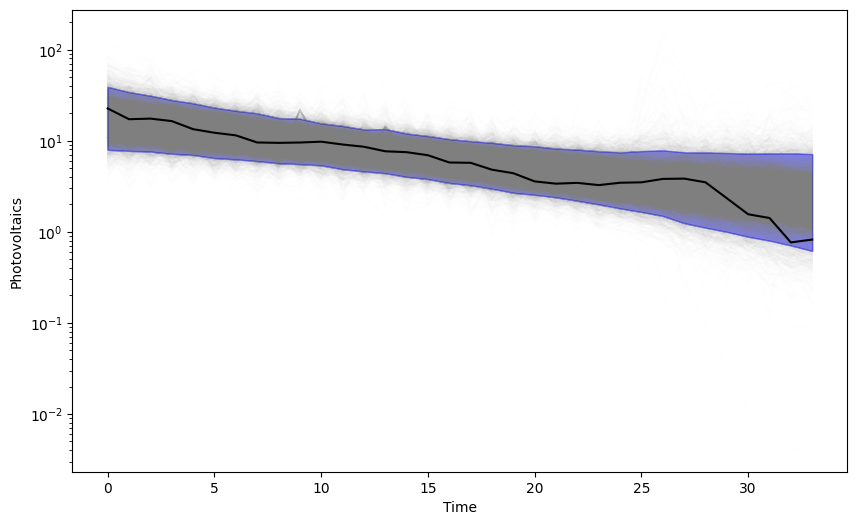

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))

for idx in range(full_samples.shape[0]):
    ax.plot(full_samples[idx], color="gray", alpha=0.005)

ax.plot(data.values, color="black", label="Observed data")

ax.fill_between(
    np.arange(len(data)),
    np.percentile(full_samples, 2.5, axis=0),
    np.percentile(full_samples, 97.5, axis=0),
    color="blue",
    alpha=0.5,
    label="95% CI",
)


ax.set_xlabel("Time")

ax.set_ylabel("Photovoltaics")

ax.set_yscale("log")

In [83]:
def create_plot(ax, data, samples, T=100, split_factor=0.6, t_points=None):

    if t_points is None:
        t_points = np.arange(T)

    # Splitting the data
    split_point = int(T * split_factor)
    train_data = data[:split_point]
    test_data = data[split_point:]

    t_train = list(range(split_point))
    t_test = list(range(split_point, T))

    # Plotting the training data
    ax.plot(t_points[t_train], train_data, "o", label="Training data", color="tab:blue")

    # Plotting the test data
    ax.plot(t_points[t_test], test_data, "o", label="Test data", color="tab:green")

    # Plotting the mean of the generated series
    ax.plot(
        t_points,
        samples.mean(axis=0),
        label="Mean of generated series",
        color="black",
    )

    # # Plotting the 95% credible interval
    # for series in all_generated_series:
    #     ax.plot(t_points, series, color="tab:gray", alpha=0.01)

    bottom_5perc = np.percentile(samples, 5, axis=0)
    top_5perc = np.percentile(samples, 95, axis=0)

    ax.fill_between(
        t_points, bottom_5perc, top_5perc, color="tab:red", alpha=0.3, label="95% CI"
    )

    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

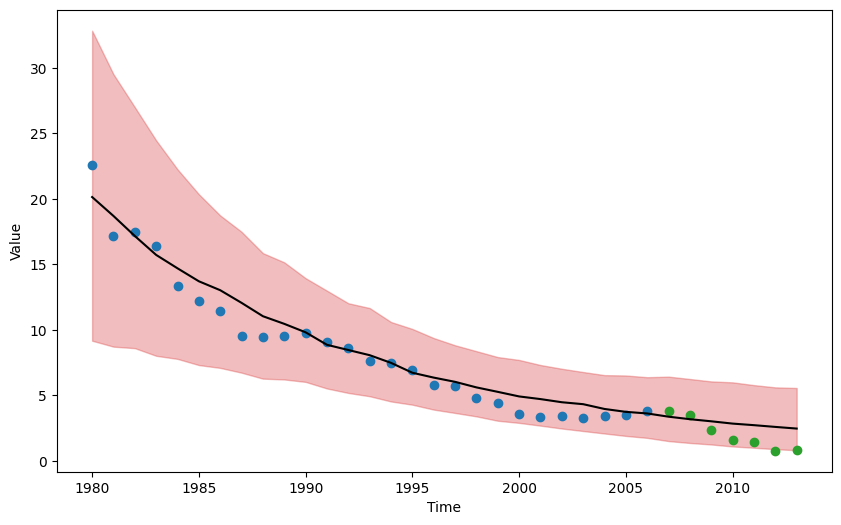

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))

create_plot(
    ax, data.values, full_samples, T=len(data), split_factor=0.8, t_points=data.index
)

Text(0, 0.5, 'Inferred Deployment')

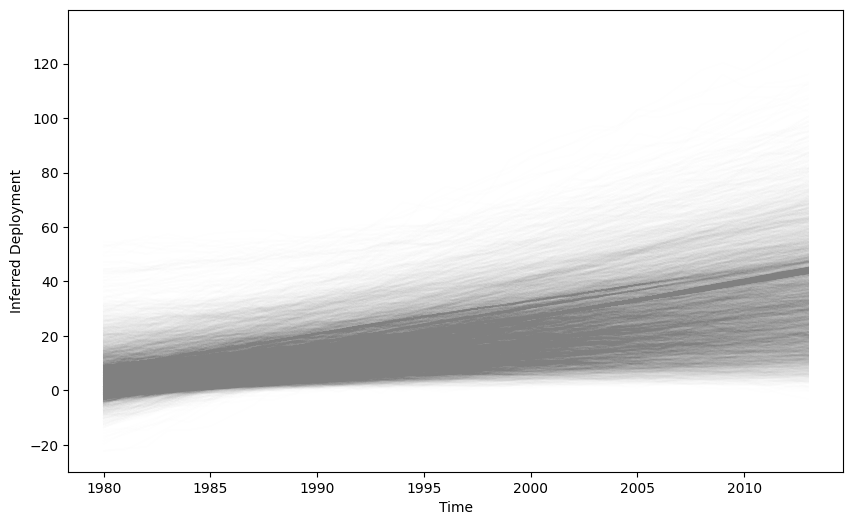

In [89]:
# plot all deployment samples

fig, ax = plt.subplots(figsize=(10, 6))

for idx in range(deployment_samples.shape[0]):
    ax.plot(data.index, -deployment_samples[idx], color="gray", alpha=0.005)

ax.set_xlabel("Time")

ax.set_ylabel("Inferred Deployment")